In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import PIL
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
ACTIONS = [['LEFT'], ['RIGHT'], ['LEFT', 'DOWN'], ['RIGHT', 'DOWN'], ['DOWN'],
           ['DOWN', 'B'], ['B']]

In [3]:
from torchvision.models import alexnet
anet = alexnet(pretrained=True)
print(anet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
from scorecam import CamExtractor, ScoreCam
from misc_functions import apply_colormap_on_image
from a2c_ppo_acktr.envs import make_vec_envs

In [5]:
model_path = "../saved-runs/05-13_04-14-36/ppo/GreenHillZone.Act1/ckpts/runs_05-13_04-14-36_ppo_GreenHillZone.Act1-1001472.pt"
model = torch.load(model_path)
print(model)

[Policy(
  (base): CNNBase(
    (main): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten()
      (7): Linear(in_features=55296, out_features=512, bias=True)
      (8): ReLU()
    )
    (critic_linear): Linear(in_features=512, out_features=1, bias=True)
  )
  (dist): Categorical(
    (linear): Linear(in_features=512, out_features=7, bias=True)
  )
), 1001472, 848, 'runs_05-13_04-14-36_ppo_GreenHillZone.Act1']


In [6]:
actor_critic = model[0]
for p in actor_critic.parameters():
    p.requires_grad = False

In [7]:
cnn_base = list(actor_critic.children())[0]
features = list(cnn_base.children())[0]
print(features)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): Flatten()
  (7): Linear(in_features=55296, out_features=512, bias=True)
  (8): ReLU()
)


In [8]:
classifier = list(actor_critic.children())[1]
print(classifier)

Categorical(
  (linear): Linear(in_features=512, out_features=7, bias=True)
)


In [15]:
from PIL import Image
from matplotlib import cm

def plot_cam_map(features, classifier, target_layer, forward_image, action):
    target_class = action
    # Score cam
    score_cam = ScoreCam(features, classifier, target_layer=target_layer)
    myarray = forward_image[0].detach().cpu().numpy()
    myarray2 = np.uint8(myarray).transpose((1,2,0))
    real_im = Image.fromarray(myarray2, 'RGB')
    display(real_im)
    # Generate cam mask
    cam = score_cam.generate_cam(forward_image, target_class)
    # Save mask    
    pic1, pic2 = apply_colormap_on_image(real_im, cam, 'hsv')
    display(pic1)
    display(pic2)

In [10]:
seed = 10
device = "cuda:0"
env_state = "GreenHillZone.Act1"
env = make_vec_envs(
    [env_state],
    seed + 1000,
    1,
    None,
    device=device,
    allow_early_resets=False,
    mode='eval')

tensor([[0.0000e+00, 5.4859e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00]], device='cuda:0')
['RIGHT']


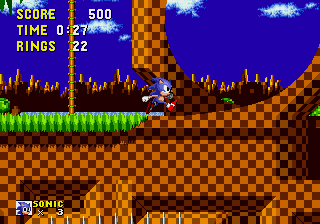

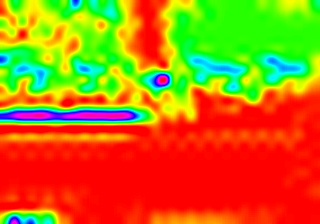

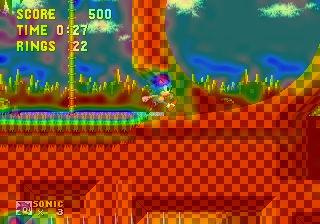

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.5654e-08]], device='cuda:0')
['B']


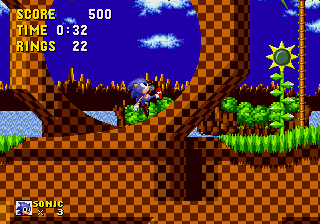

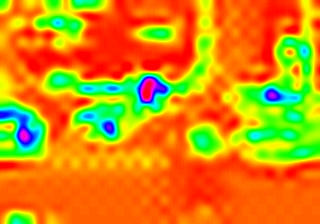

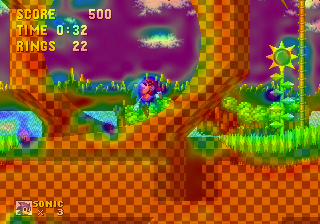

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.3054e-12]], device='cuda:0')
['B']


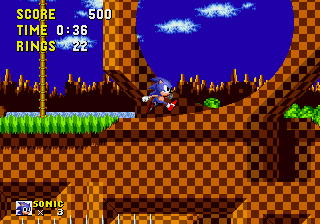

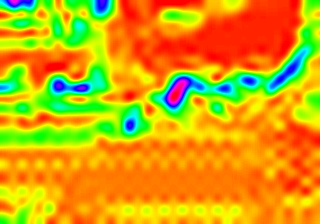

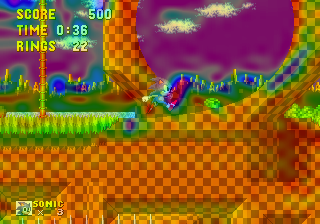

tensor([[0.0000, 0.8584, 0.0000, 0.0000, 0.0000, 0.1416, 0.0000]],
       device='cuda:0')
['RIGHT']


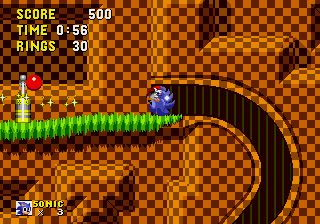

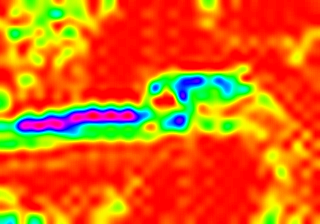

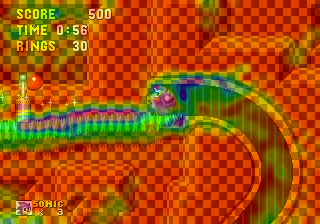

tensor([[0.0000, 0.0036, 0.0000, 0.0000, 0.0000, 0.0046, 0.9917]],
       device='cuda:0')
['B']


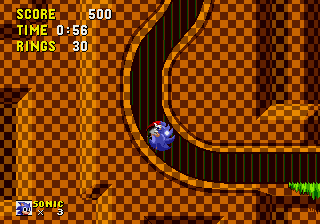

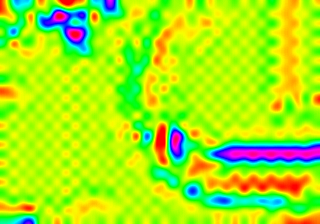

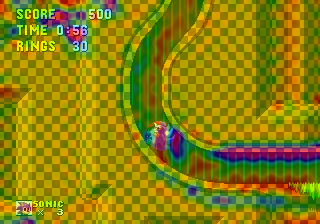

tensor([[0.0000e+00, 2.7973e-41, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.9998e-01,
         1.8127e-05]], device='cuda:0')
['B']


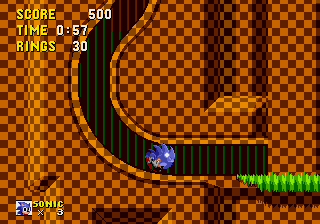

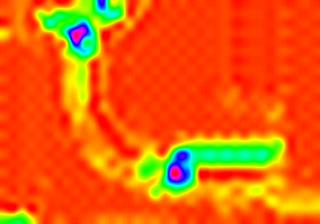

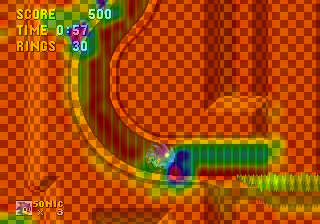

max_x 9572, stage len 9407


In [16]:
recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size).to(device)
masks = torch.zeros(1, 1).to(device)

obs = env.reset()
i = 0
while True:
    with torch.no_grad():
        value, action, _, recurrent_hidden_states = actor_critic.act(
            obs, recurrent_hidden_states, masks, deterministic=True)
    
    probs = classifier(features(obs)).probs
    if probs[0][action.item()] != 1:
        print(probs)
        print(ACTIONS[action.item()])
        plot_cam_map(features, classifier, 5, obs, action.item())

    # Obser reward and next obs
    obs, reward, done, info = env.step(action)
    masks.fill_(0.0 if done else 1.0)
    
    if done:
        print(f"max_x {info[0]['max_x']}, stage len {info[0]['screen_x_end']}")
        break
    i += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.43070188
-0.3740541


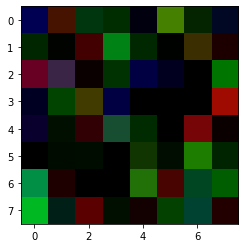

In [12]:
for m in actor_critic.modules():
    if isinstance(m, nn.Conv2d):
        data = m.weight.cpu().numpy()
        print(np.max(data))
        print(np.min(data))
        abs_max = max(abs(np.max(data)), abs(np.min(data)))
        for f in range(data.shape[0]):
            plt.imshow(data[f].transpose((1,2,0)) / abs_max, interpolation='nearest')
            plt.show()
            break
        break
#             for c in range(data.shape[1]):
#                 plt.imshow(data[f][c], interpolation='nearest')
#                 plt.show()